In [1]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [5]:
root = 'data'

In [6]:
import os

In [7]:
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [8]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

In [9]:
class_name = train_data.classes

In [10]:
class_name

['with_mask', 'without_mask']

In [11]:
len(train_data)

6041

In [12]:
len(test_data)

1512

In [13]:
class FaceMask(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(16*54*54,layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], 2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 16*54*54)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x,dim=1)

In [14]:
model = FaceMask(layers=[100,50]).cuda()

In [15]:
model

FaceMask(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# import time
# start_time = time.time()


# epochs = 3
# max_trn_batch = 300
# max_tst_batch = 95

# train_losses = []
# test_losses = []
# train_correct = []
# test_correct = []

# for i in range(epochs):
#     train_corr = 0
#     test_corr = 0
    
#     for b,(X_train,y_train) in enumerate(train_loader):
#         X_train = X_train.cuda()
#         y_train = y_train.cuda()
        
#         if b == max_trn_batch:
#             break
#         b += 1
#         y_pred = model(X_train)
#         loss = criterion(y_pred, y_train)
        
#         predicted = torch.max(y_pred.data, 1)[1]
#         batch_corr = (predicted==y_train).sum()
#         train_corr += batch_corr
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if b%100 == 0:
#             print(f"epoch {i} loss: {loss.item()} training_accuracy: {train_corr.item()*100/(10*b):7.3f}%")
            
#     train_losses.append(loss)
#     train_correct.append(train_corr)
    
#     #TEST
#     with torch.no_grad():
#         for b,(X_test, y_test) in enumerate(test_loader):
#             X_test = X_test.cuda()
#             y_test = y_test.cuda()
#             if b == max_tst_batch:
#                 break
                
#             y_val = model(X_test)
#             predicted = torch.max(y_val.data, 1)[1]
#             batch_corr = (predicted==y_test).sum()
#             test_corr = test_corr + batch_corr

#             # if b%100 == 0:
#             #     print(f"Test accuracy: {test_correct[-1].item()*100/(10*max_tst_batch):.3f}%")
            
#     loss = criterion(y_val, y_test)
#     test_losses.append(loss)
#     test_correct.append(test_corr)

    
# total_time = time.time() - start_time
# print(f'total_time: {total_time/60} minutes')

epoch 0 loss: 0.2843326926231384 training_accuracy:  76.800%
epoch 0 loss: 0.7940149307250977 training_accuracy:  82.000%
epoch 0 loss: 0.21870525181293488 training_accuracy:  83.933%
epoch 1 loss: 0.023881729692220688 training_accuracy:  91.000%
epoch 1 loss: 0.2727000117301941 training_accuracy:  90.200%
epoch 1 loss: 0.3870072364807129 training_accuracy:  89.333%
epoch 2 loss: 0.9893316030502319 training_accuracy:  88.500%
epoch 2 loss: 0.033467136323451996 training_accuracy:  89.350%
epoch 2 loss: 0.009609694592654705 training_accuracy:  90.267%
total_time: 3.3976973414421083 minutes


In [24]:
# torch.save(model.state_dict(), 'py_fm.pt')

In [23]:
# torch.save(model, 'facemask.pkl')

In [18]:
import matplotlib.pyplot as plt

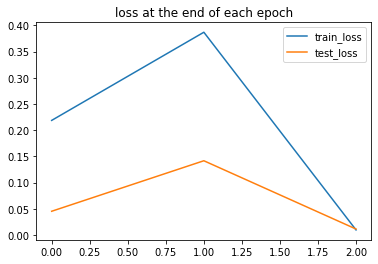

In [19]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.title('loss at the end of each epoch')
plt.legend()

In [20]:
print(f'Test accuracy: {test_correct[-1].item()*100/(10*max_tst_batch):.3f}%')

Test accuracy: 89.368%


In [21]:
import numpy as np

In [25]:
model = torch.load('facemask.pkl')

In [26]:
# model

In [27]:
def detect_mask(img):
    model.eval()

    with torch.no_grad():
        new_pred = model(img.view(1,3,224,224).cuda()).argmax()
        
    # print(class_name[new_pred])
    # print(new_pred)
    return new_pred

In [28]:
img_transform = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

# img = Image.open("test_img/with_mask_14.jpg")
img = cv2.imread("test_img/with_mask_14.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
new_img = img_transform(img)

detect_mask(new_img)


tensor(0, device='cuda:0')

In [29]:
def draw_label(img, text, pos, bg_color):
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX,1, cv2.FILLED)
    end_x = pos[0] + text_size[0][0] +2
    end_y = pos[1] + text_size[0][1] -2
    
    cv2.rectangle(img, pos, (end_x, end_y), bg_color, cv2.FILLED)
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_COMPLEX,1,(0,0,0), 1, cv2.LINE_AA)

In [30]:
img_transform = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

In [35]:
haar_data = cv2.CascadeClassifier('data.xml')

def detect_face(img):
    cords = haar_data.detectMultiScale(img)

    return cords

In [39]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    img = cv2.resize(frame, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.medianBlur(img,5)
    img = Image.fromarray(img)
    img = img_transform(img)
    y_pred = detect_mask(img)

    cords = detect_face(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    for x,y,w,h in cords:
        cv2.rectangle(frame,(x,y),(x+w, y+h),(255,0,0),4)

    if y_pred == 0:
        draw_label(frame, 'mask', (35,35), (0,255,0))
    else:
        draw_label(frame, 'no_mask', (35,35), (0,0,255))

    cv2.imshow('window', frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()   
cv2.destroyAllWindows()